Hypothesis 

(Inspiration : "You might want to test if the average client tenure (how long they've been with Vanguard) of those engaging with the new process is the same as those engaging with the old process")


Do low-engagement customers benefit more from the new UI than high-engagement customers?

- High-engagement users ("power users") already know the platform well
- A simpler UI should help confused users more than experienced users



Null Hypothesis (H₀):
The conversion rate improvement (Test - Control) is the same for low-engagement and high-engagement customers.

Alternative Hypothesis (H₁):  
The conversion rate improvement is different bteween low-engagement customers and for high-engagement customers.



In [3]:
# Import  libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")



In [12]:
df_engagement = pd.read_csv("final_experiment_dataset.csv")

print(len(df_engagement))
print(len(df_engagement.columns))


56252
18


In [9]:
# Check how many customers are in each group (Control vs Test)
print("Distribution of customers by variation:")
print(df_engagement['Variation'].value_counts())
print()
print(f"Control group: {len(df_engagement[df_engagement['Variation'] == 'Control']):,} customers")
print(f"Test group: {len(df_engagement[df_engagement['Variation'] == 'Test']):,} customers")

Distribution of customers by variation:
Variation
Test       29970
Control    26282
Name: count, dtype: int64

Control group: 26,282 customers
Test group: 29,970 customers


In [11]:
# Engagement metrics:
print("Engagement Metrics Summary:")
print()
print("calls_6_mnth (Number of calls in last 6 months):")
print(df_engagement['calls_6_mnth'].describe())
print()
print("logons_6_mnth (Number of logins in last 6 months):")
print(df_engagement['logons_6_mnth'].describe())

Engagement Metrics Summary:

calls_6_mnth (Number of calls in last 6 months):
count    56252.000000
mean         3.167656
std          2.193165
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max          6.000000
Name: calls_6_mnth, dtype: float64

logons_6_mnth (Number of logins in last 6 months):
count    56252.000000
mean         6.205699
std          2.180585
min          3.000000
25%          4.000000
50%          6.000000
75%          9.000000
max          9.000000
Name: logons_6_mnth, dtype: float64


Engagement level :  3 categories based on customer behavior:
- Low --> Few calls and few logins
- Medium --> Moderate activity
- High --> Many calls and many logins ("power users")

Choices:
Low Engagement:    calls_6_mnth <= 2  AND  logons_6_mnth <= 5
High Engagement:   calls_6_mnth >= 5  AND  logons_6_mnth >= 8
Medium Engagement: Everyone else


In [13]:
# Create a new column for engagement level
df_engagement['engagement_level'] = 'Medium'

# Define Low engagement: <= 2 calls AND <= 5 logins
low_engagement_mask = (df_engagement['calls_6_mnth'] <= 2) & (df_engagement['logons_6_mnth'] <= 5)
df_engagement.loc[low_engagement_mask, 'engagement_level'] = 'Low'

# Define High engagement: >= 5 calls AND >= 8 logins    # power users clients
high_engagement_mask = (df_engagement['calls_6_mnth'] >= 5) & (df_engagement['logons_6_mnth'] >= 8)
df_engagement.loc[high_engagement_mask, 'engagement_level'] = 'High'


✓ Engagement levels created successfully!


In [17]:
# Check the distribution of engagement levels

engagement_counts = df_engagement['engagement_level'].value_counts()

for level in ['Low', 'Medium', 'High']:
    count = engagement_counts.get(level, 0)
    percentage = (count / len(df_engagement)) * 100
    print(f"{level:10s}: {count:6,} customers ({percentage:5.2f}%)")

print(f"Total:{len(df_engagement):6,} customers")

Low       : 24,208 customers (43.03%)
Medium    : 12,339 customers (21.94%)
High      : 19,705 customers (35.03%)
Total:      56,252 customers


In [19]:
#Conversion Rate = (Number of customers who converted) / (Total number of customers

results = []

for engagement in ['Low', 'Medium', 'High']:
    for variation in ['Control', 'Test']:
        # Filter the data for this specific combination
        subset = df_engagement[(df_engagement['engagement_level'] == engagement) & 
                    (df_engagement['Variation'] == variation)]
        
 
        n_total = len(subset)
        n_converted = subset['converted'].sum()  # True = 1, False = 0
        conversion_rate = (n_converted / n_total) if n_total > 0 else 0
        
   
        results.append({
            'Engagement': engagement,
            'Variation': variation,
            'Total_Customers': n_total,
            'Converted': n_converted,
            'Conversion_Rate': conversion_rate
        })

# Convert to DataFrame for easier viewing
results_df = pd.DataFrame(results)

print("Conversion Rates by Engagement Level and Variation:")
results_df

Conversion Rates by Engagement Level and Variation:


,Engagement,Variation,Total_Customers,Converted,Conversion_Rate
0,Low,Control,11205,6186,0.552075
1,Low,Test,13003,8278,0.636622
2,Medium,Control,5717,3111,0.544167
3,Medium,Test,6622,4226,0.638176
4,High,Control,9360,4865,0.519765
5,High,Test,10345,6600,0.637989


In [21]:
for engagement in ['Low', 'Medium', 'High']:
    print(f"\n{engagement} Engagement:")
    
    for variation in ['Control', 'Test']:
        row = results_df[(results_df['Engagement'] == engagement) & 
                         (results_df['Variation'] == variation)].iloc[0]
        
        print(f"  {variation:8s}: {row['Conversion_Rate']:.2%} "
              f"({row['Converted']}/{row['Total_Customers']})")


Low Engagement:
  Control : 55.21% (6186/11205)
  Test    : 63.66% (8278/13003)

Medium Engagement:
  Control : 54.42% (3111/5717)
  Test    : 63.82% (4226/6622)

High Engagement:
  Control : 51.98% (4865/9360)
  Test    : 63.80% (6600/10345)


In [23]:
# Calculate lift for each engagement level

# Absolute Lift = Test Conversion Rate - Control Conversion Rate
# Relative Lift = (Absolute Lift / Control Rate) × 100%

lifts = []

for engagement in ['Low', 'Medium', 'High']:
    # Get the conversion rates for Control and Test
    control_rate = results_df[
        (results_df['Engagement'] == engagement) & 
        (results_df['Variation'] == 'Control')
    ]['Conversion_Rate'].values[0]
    
    test_rate = results_df[
        (results_df['Engagement'] == engagement) & 
        (results_df['Variation'] == 'Test')
    ]['Conversion_Rate'].values[0]
    
    # Calculate lifts
    absolute_lift = test_rate - control_rate
    relative_lift = (absolute_lift / control_rate) * 100 if control_rate > 0 else 0
    
    lifts.append({
        'Engagement': engagement,
        'Control_Rate': control_rate,
        'Test_Rate': test_rate,
        'Absolute_Lift': absolute_lift,
        'Relative_Lift': relative_lift
    })

# Convert to DataFrame
lifts_df = pd.DataFrame(lifts)

print(lifts_df)

  Engagement  Control_Rate  Test_Rate  Absolute_Lift  Relative_Lift
0        Low      0.552075   0.636622       0.084547      15.314469
1     Medium      0.544167   0.638176       0.094009      17.275825
2       High      0.519765   0.637989       0.118224      22.745745


In [27]:
#Details

for _, row in lifts_df.iterrows():
    print(f"\n{row['Engagement']} Engagement:")

    print(f"  Control Rate (Old UI):  {row['Control_Rate']:.2%}")
    print(f"  Test Rate (New UI):     {row['Test_Rate']:.2%}")
    print(f"  Absolute Lift:          {row['Absolute_Lift']:+.2%} ({row['Absolute_Lift']*100:+.2f} percentage points)")
    print(f"  Relative Lift:          {row['Relative_Lift']:+.2f}% improvement")


Low Engagement:
  Control Rate (Old UI):  55.21%
  Test Rate (New UI):     63.66%
  Absolute Lift:          +8.45% (+8.45 percentage points)
  Relative Lift:          +15.31% improvement

Medium Engagement:
  Control Rate (Old UI):  54.42%
  Test Rate (New UI):     63.82%
  Absolute Lift:          +9.40% (+9.40 percentage points)
  Relative Lift:          +17.28% improvement

High Engagement:
  Control Rate (Old UI):  51.98%
  Test Rate (New UI):     63.80%
  Absolute Lift:          +11.82% (+11.82 percentage points)
  Relative Lift:          +22.75% improvement


In [35]:
# Perform Chi-Square test for each engagement level
from scipy.stats import chi2_contingency

print("Chi-Square Statistical Tests")

print("\nTesting: Is the difference between Control and Test significant?")
print("(at α = 0.05 significance level)\n")

test_results = []

for engagement in ['Low', 'Medium', 'High']:
    print(f"{engagement} Engagement Customers:")

    # Filter data for this engagement level
    subset = df_engagement[df_engagement['engagement_level'] == engagement]
    
    # Create a contingency table: Variation (rows) × Converted (columns)
    contingency_table = pd.crosstab(
        subset['Variation'], 
        subset['converted']
    )
    
    print("\nContingency Table:")
    print(contingency_table)
    
    # Perform Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate effect size (Cramér's V)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / n)
    
    # Store results
    test_results.append({
        'Engagement': engagement,
        'Chi2': chi2,
        'P_value': p_value,
        'Cramers_V': cramers_v,
        'Significant': p_value < 0.05
    })
    
    # Display results
    print(f"\nTest Results:")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Effect size (Cramér's V): {cramers_v:.4f}")
    
    if p_value < 0.05:
        print(f" The new UI does make a significant difference for {engagement.lower()}-engagement customers")
    else:
        print(f"The difference might be due to chance")



Chi-Square Statistical Tests

Testing: Is the difference between Control and Test significant?
(at α = 0.05 significance level)

Low Engagement Customers:

Contingency Table:
converted  False  True 
Variation              
Control     5019   6186
Test        4725   8278

Test Results:
  Chi-square statistic: 178.5397
  P-value: 0.000000
  Effect size (Cramér's V): 0.0859
 The new UI does make a significant difference for low-engagement customers
Medium Engagement Customers:

Contingency Table:
converted  False  True 
Variation              
Control     2606   3111
Test        2396   4226

Test Results:
  Chi-square statistic: 112.1010
  P-value: 0.000000
  Effect size (Cramér's V): 0.0953
 The new UI does make a significant difference for medium-engagement customers
High Engagement Customers:

Contingency Table:
converted  False  True 
Variation              
Control     4495   4865
Test        3745   6600

Test Results:
  Chi-square statistic: 281.8045
  P-value: 0.000000
  Effect siz

In [37]:

test_results_df = pd.DataFrame({
    'Test': ['Chi-Square Test'],  # Add more test names as needed
    'Statistic': [chi2],
    'P-Value': [p_value],
    'Degrees of Freedom': [dof],
    'Significant (α=0.05)': [p_value < 0.05]
})

print("SUMMARY: Statistical Test Results")
print()
print(test_results_df)
print("SUMMARY: Statistical Test Results")
print()
test_results_df

SUMMARY: Statistical Test Results

              Test   Statistic       P-Value  Degrees of Freedom  \
0  Chi-Square Test  281.804508  3.036457e-63                   1   

   Significant (α=0.05)  
0                  True  
SUMMARY: Statistical Test Results



,Test,Statistic,P-Value,Degrees of Freedom,Significant (α=0.05)
0,Chi-Square Test,281.804508,3.036457e-63,1,True


P-value interpretation:
- p < 0.001: Very strong evidence (***)
- p < 0.01: Strong evidence (**)
- p < 0.05: Moderate evidence (*)
- p ≥ 0.05: Insufficient evidence

Cramér's V (effect size):
- < 0.1: Small effect
- 0.1-0.3: Medium effect
- > 0.3: Large effect

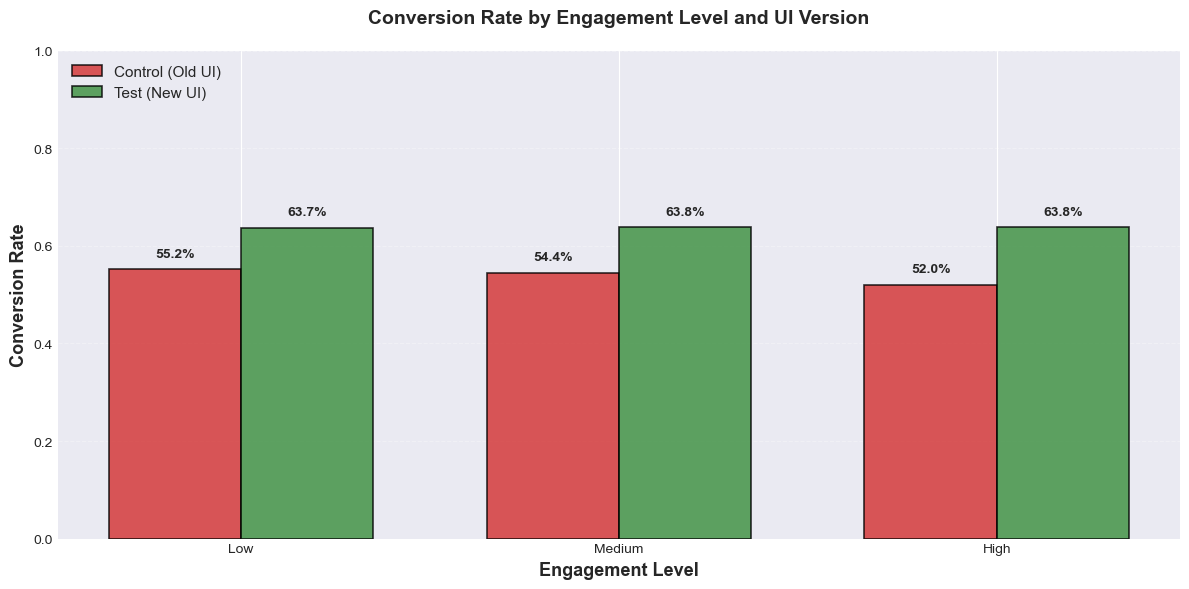

In [38]:
# Chart 1: Conversion Rates by Engagement Level
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data
x_pos = np.arange(3)
width = 0.35

control_rates = [lifts_df[lifts_df['Engagement'] == e]['Control_Rate'].values[0] 
                 for e in ['Low', 'Medium', 'High']]
test_rates = [lifts_df[lifts_df['Engagement'] == e]['Test_Rate'].values[0] 
              for e in ['Low', 'Medium', 'High']]

# Create bars
bars1 = ax.bar(x_pos - width/2, control_rates, width, 
               label='Control (Old UI)', color='#D32F2F', alpha=0.8, 
               edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x_pos + width/2, test_rates, width, 
               label='Test (New UI)', color='#388E3C', alpha=0.8, 
               edgecolor='black', linewidth=1.2)

# Customize
ax.set_xlabel('Engagement Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Conversion Rate', fontsize=13, fontweight='bold')
ax.set_title('Conversion Rate by Engagement Level and UI Version', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_ylim(0, 1)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (ctrl, test) in enumerate(zip(control_rates, test_rates)):
    ax.text(i - width/2, ctrl + 0.02, f'{ctrl:.1%}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')
    ax.text(i + width/2, test + 0.02, f'{test:.1%}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()



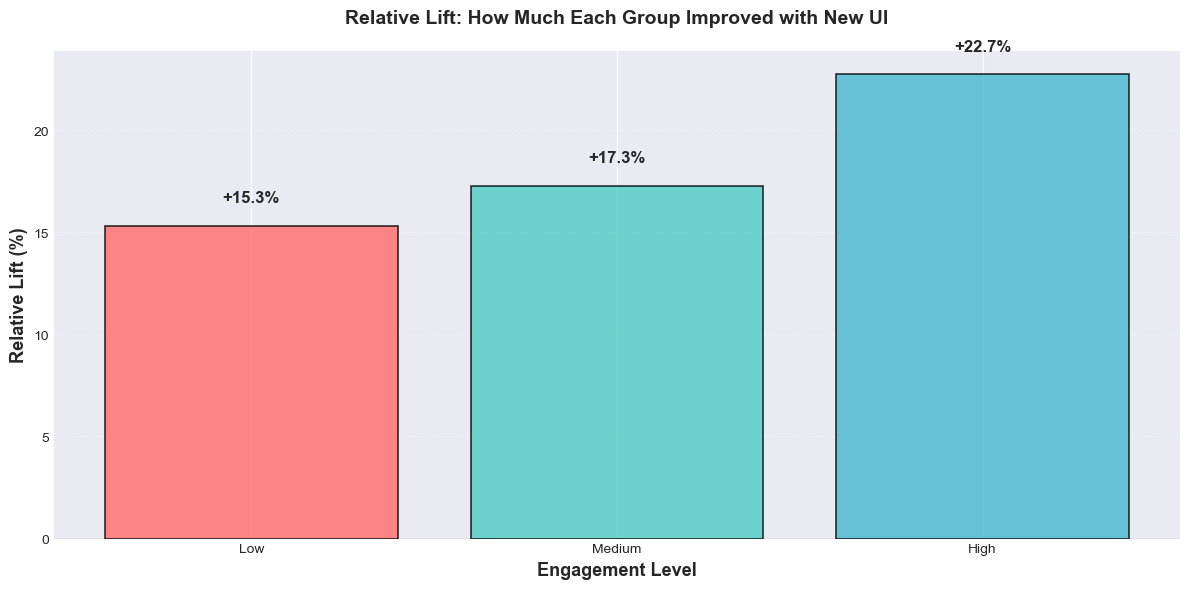

In [ ]:
# Chart 2: Relative Lift by Engagement Level
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data
lifts_pct = [lifts_df[lifts_df['Engagement'] == e]['Relative_Lift'].values[0] 
             for e in ['Low', 'Medium', 'High']]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Create bars
bars = ax.bar(['Low', 'Medium', 'High'], lifts_pct, 
              color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

# Customize
ax.set_xlabel('Engagement Level', fontsize=13, fontweight='bold')
ax.set_ylabel('Relative Lift (%)', fontsize=13, fontweight='bold')
ax.set_title('Relative Lift: How Much Each Group Improved with New UI', 
             fontsize=14, fontweight='bold', pad=20)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, lift) in enumerate(zip(bars, lifts_pct)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{lift:+.1f}%', ha='center', va='bottom', 
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()




In [55]:
# Extract the relative lifts
low_lift = lifts_df[lifts_df['Engagement'] == 'Low']['Relative_Lift'].values[0]
medium_lift = lifts_df[lifts_df['Engagement'] == 'Medium']['Relative_Lift'].values[0]
high_lift = lifts_df[lifts_df['Engagement'] == 'High']['Relative_Lift'].values[0]

print("\nRecall our hypothesis:")
print("  H₀: The lift is the same across all engagement levels")
print("  H₁: The lift is not the same across all engagement levels")


print("Observed Relative Lifts:")
print(f"  Low Engagement:    {low_lift:+.2f}%")
print(f"  Medium Engagement: {medium_lift:+.2f}%")
print(f"  High Engagement:   {high_lift:+.2f}%")



if low_lift > high_lift:
    print(f"   - Low engagement shows {low_lift:.1f}% lift")
    print(f"   - High engagement shows {high_lift:.1f}% lift")
    print(f"   - Difference: {low_lift - high_lift:.2f} percentage points")
else:
    print(f"   - Low engagement shows {low_lift:.1f}% lift")
    print(f"   - High engagement shows {high_lift:.1f}% lift")
    print(f"   - Difference: {high_lift - low_lift:.2f} percentage points in favor of different lift")
  

# Find which group benefited most
max_lift_level = lifts_df.loc[lifts_df['Relative_Lift'].idxmax(), 'Engagement']
max_lift_value = lifts_df['Relative_Lift'].max()

 
 


Recall our hypothesis:
  H₀: The lift is the same across all engagement levels
  H₁: The lift is not the same across all engagement levels
Observed Relative Lifts:
  Low Engagement:    +15.31%
  Medium Engagement: +17.28%
  High Engagement:   +22.75%
   - Low engagement shows 15.3% lift
   - High engagement shows 22.7% lift
   - Difference: 7.43 percentage points in favor of different lift


 ## Interpretation: Power users actually appreciate the new UI more (counter intuitive)